## Import Package

In [1]:
#!pip install optuna
#!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import optuna
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KDTree
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV
# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import lightgbm as lgbm
import catboost as cat
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE

import optuna
import warnings
warnings.filterwarnings("ignore")

c:\Users\Chuxu\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Chuxu\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Upload Datasets

In [3]:
data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore.csv")
data.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [4]:
data.shape

(10841, 13)

# Descriptive Analysis

## Data Cleaning

In [5]:
data = data.drop(['App','Current Ver','Android Ver'], axis=1)
# data = data.drop(['App','Current Ver','Android Ver'], axis=1)
# # Convert the 'last_updated' column to datetime, specifying the format
# data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%B %d, %Y')

# # Reference date (e.g., today's date)
# reference_date = pd.Timestamp.now()

# # Calculate the number of days since the last update
# data['days_since_last_update'] = (reference_date - data['last_updated']).dt.days

# print(data)

In [6]:
data[~data.Reviews.str.isnumeric()]

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
10472,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19


In [7]:
data=data.drop(data.index[10472])

In [8]:
items_to_remove=['+',',','$'] # Remove special symbols
cols_to_clean=['Installs','Price','Size']
for item in items_to_remove:
    for col in cols_to_clean:
        data[col]=data[col].str.replace(item,'')

In [9]:
data['Installs'] = data['Installs'].astype('int') # Change data type
data['Price'] = data['Price'].astype('float')
data['Reviews'] = data['Reviews'].astype('int')
data['Size'] = data['Size'].str.replace('M','000')
data['Size'] = data['Size'].str.replace('k','')
data['Size'] = data['Size'].replace("Varies with device",np.nan)
data['Size'] = data['Size'].astype('float')
for i in data['Size']:
    if i < 10:
        data['Size'] = data['Size'].replace(i,i*1000)
data['Size'] = data['Size']/1000

In [10]:
null = pd.DataFrame({'Null Values':data.isna().sum().sort_values(ascending=False),
                   'Percentage Null Values':(data.isna().sum().sort_values(ascending=False))/(data.shape[0])*(100)})

In [11]:
data=data.dropna() # Remove all null value

In [12]:
null = pd.DataFrame({'Null Values':data.isna().sum().sort_values(ascending=False),
'Percentage Null Values':(data.isna().sum().sort_values(ascending=False))/(data.shape[0])*(100)})
null
data.shape

(7729, 10)

In [13]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018"
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018"
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018"
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018"
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018"


In [14]:
duplicate = data.duplicated()
print(duplicate.sum())
data.drop_duplicates(inplace=True)
duplicate = data.duplicated()
print(duplicate.sum())

307
0


In [15]:
# Convert the 'last_updated' column to datetime, specifying the format
data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%B %d, %Y')
# Reference date (e.g., today's date)
reference_date = pd.to_datetime("2018-08-08")
# Calculate the number of days since the last update
data['days_since_last_update'] = (reference_date - data['Last Updated']).dt.days
data = data.drop(['Last Updated'], axis=1)
print(data)
print(data['days_since_last_update'].min())

                  Category  Rating  Reviews    Size  Installs  Type  Price  \
0           ART_AND_DESIGN     4.1      159  19.000     10000  Free    0.0   
1           ART_AND_DESIGN     3.9      967  14.000    500000  Free    0.0   
2           ART_AND_DESIGN     4.7    87510   8.700   5000000  Free    0.0   
3           ART_AND_DESIGN     4.5   215644  25.000  50000000  Free    0.0   
4           ART_AND_DESIGN     4.3      967   2.800    100000  Free    0.0   
...                    ...     ...      ...     ...       ...   ...    ...   
10833  BOOKS_AND_REFERENCE     4.8       44   0.619      1000  Free    0.0   
10834               FAMILY     4.0        7   2.600       500  Free    0.0   
10836               FAMILY     4.5       38  53.000      5000  Free    0.0   
10837               FAMILY     5.0        4   3.600       100  Free    0.0   
10840            LIFESTYLE     4.5   398307  19.000  10000000  Free    0.0   

      Content Rating                     Genres  days_since_las

## Data Visualization

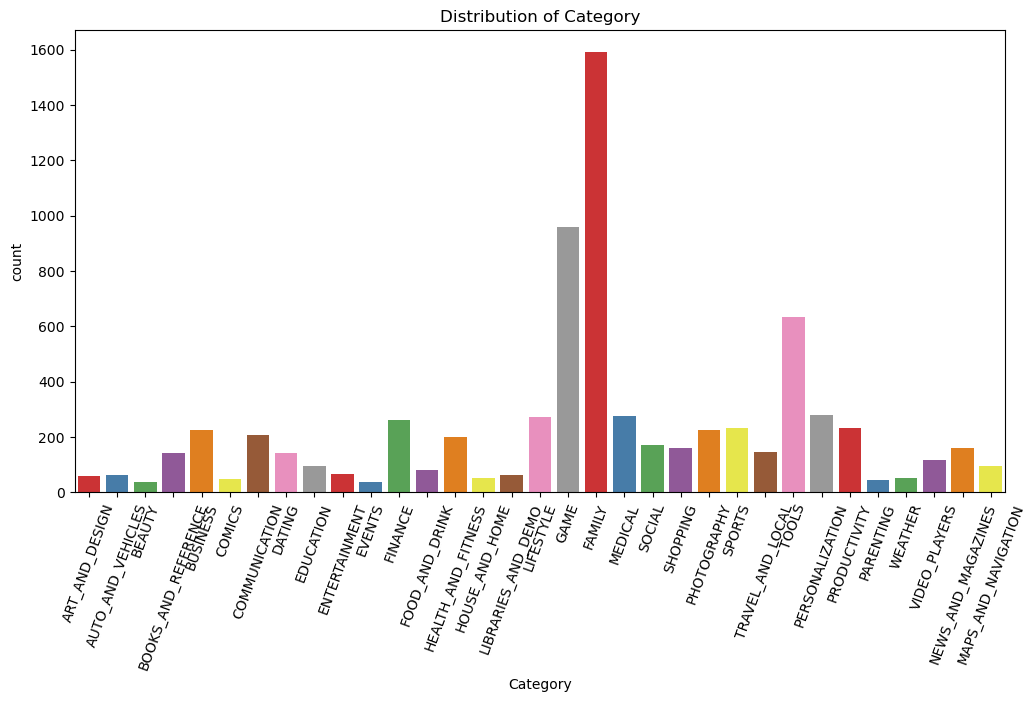

In [16]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Category',data=data,palette="Set1")
plt.xticks(rotation=70)
plt.title("Distribution of Category")
plt.show()

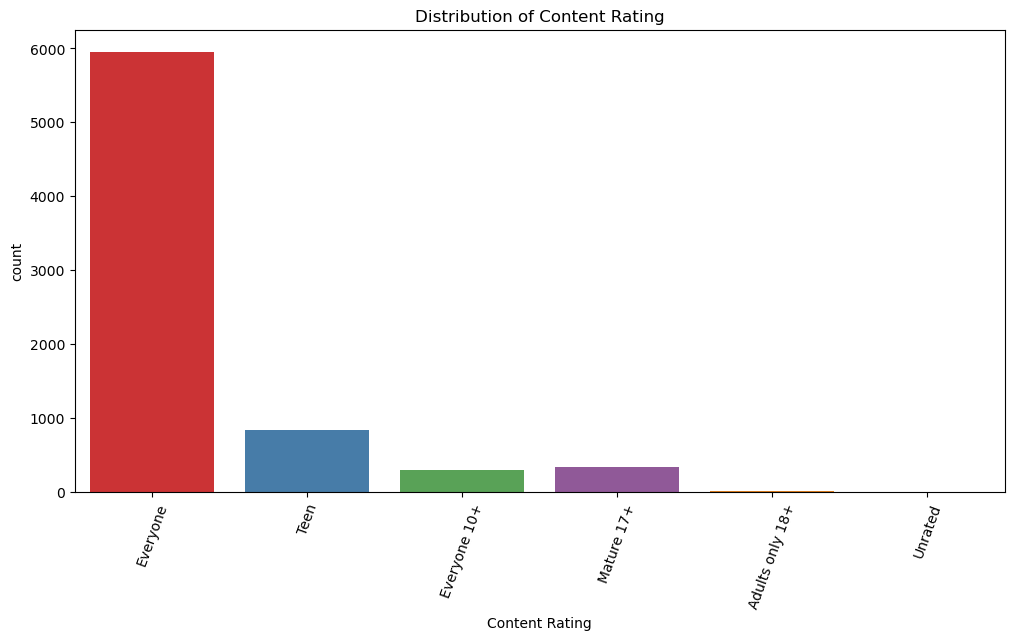

In [17]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Content Rating',data=data,palette="Set1")
plt.title("Distribution of Content Rating")
plt.xticks(rotation=70)
plt.show()

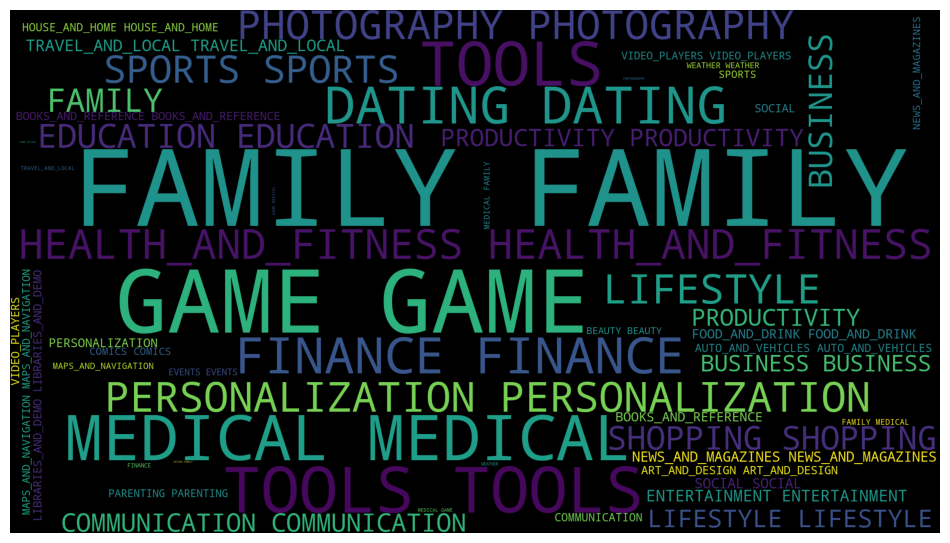

In [18]:
plt.subplots(figsize=(12,8))
wordcloud = WordCloud(background_color='black',width=1920,height=1080).generate(" ".join(data.Category))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

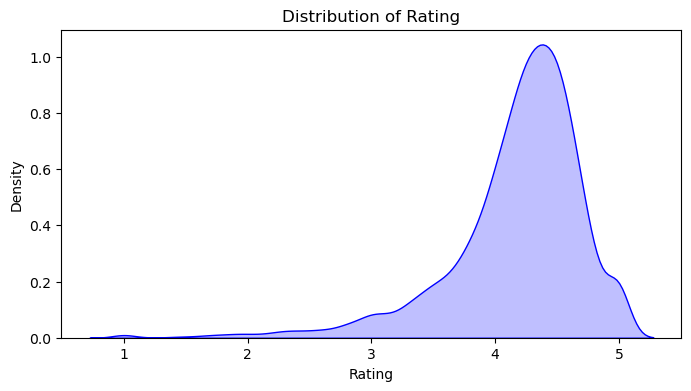

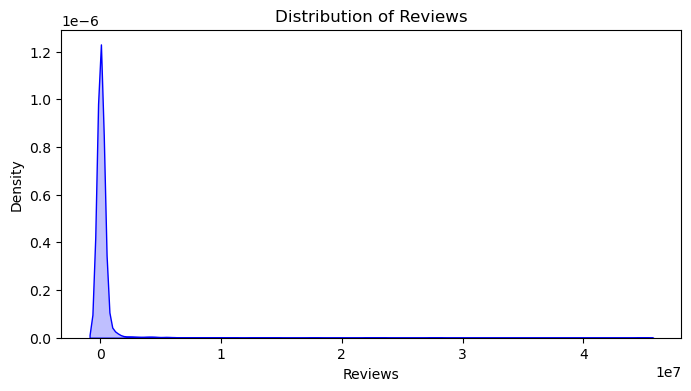

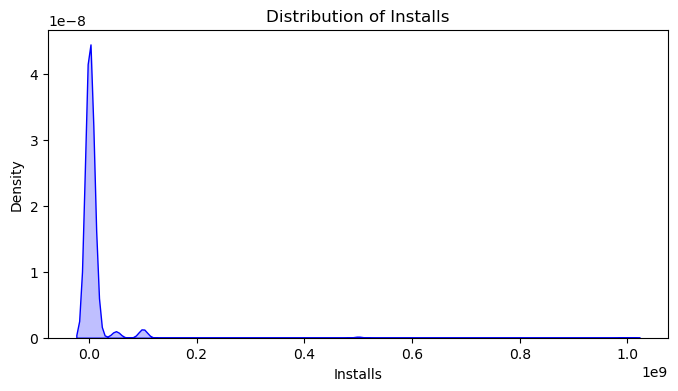

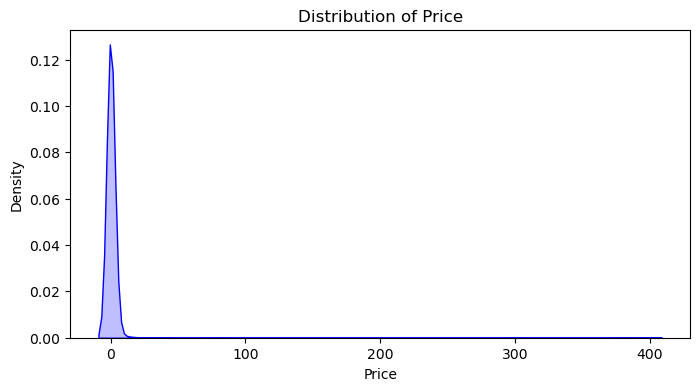

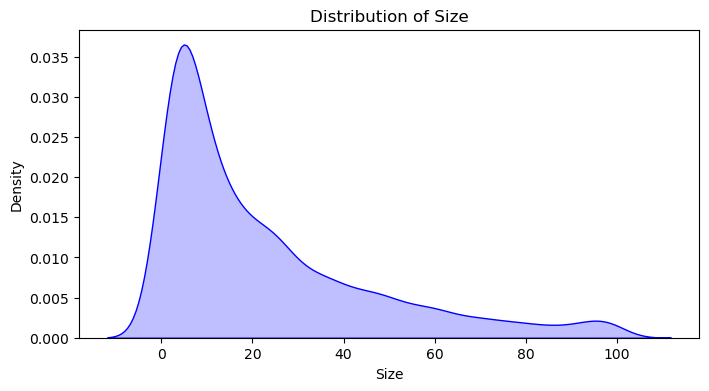

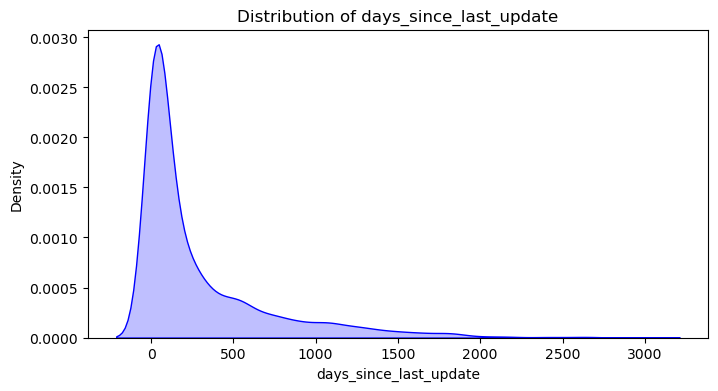

In [19]:
numeric_cols = ['Rating', 'Reviews', 'Installs', 'Price', 'Size', 'days_since_last_update']
for i in range(6):
  plt.figure(figsize=(8,4))
  sns.kdeplot(data[numeric_cols[i]],color='blue',fill=True)
  plt.title("Distribution of "+numeric_cols[i])

<Axes: >

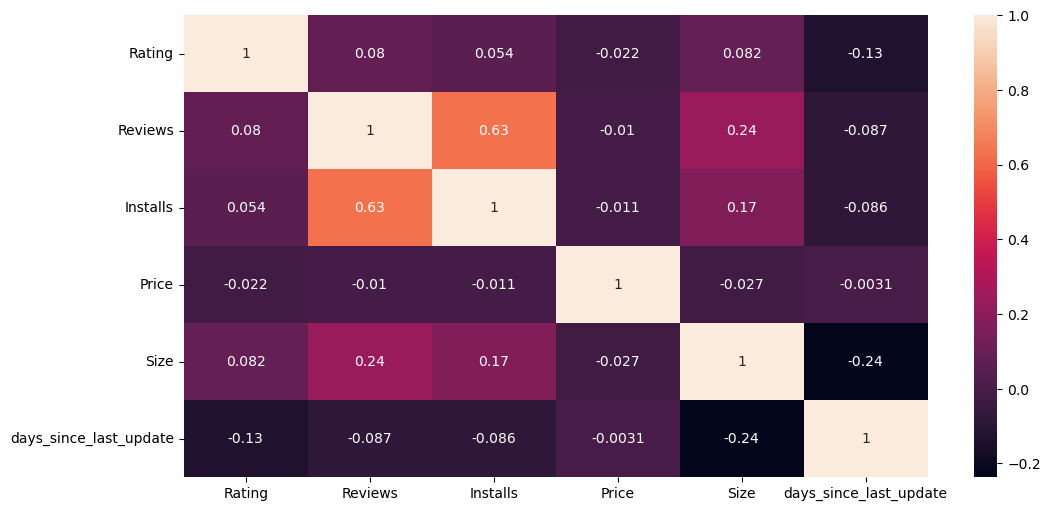

In [20]:
sns.heatmap(data[numeric_cols].corr(),annot=True)

## Data Encoding

In [21]:
def categorize_rating(rating):
    if rating >= 1 and rating < 4.0:
        return 1
    elif rating >= 4.0 and rating < 4.5:
        return 2
    elif rating >= 4.5 and rating <= 5:
        return 3
    else:
        return np.nan  # Return NaN for ratings that don't match any condition
# Apply the function to the 'Rating' column to create the 'Rating Interval' column
data['Rating Interval'] = data['Rating'].apply(categorize_rating)
#1-4

In [22]:
data['Rating Interval'].value_counts()

Rating Interval
2    3299
3    2366
1    1757
Name: count, dtype: int64

<BarContainer object of 3 artists>

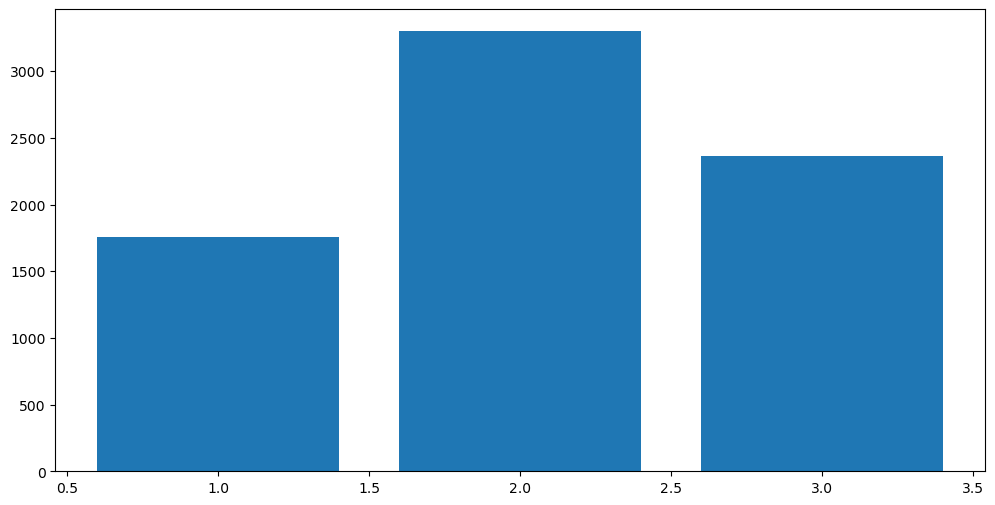

In [23]:
plt.bar(data['Rating Interval'].value_counts().index,data['Rating Interval'].value_counts())

In [24]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,days_since_last_update,Rating Interval
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,213,2
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,205,1
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,7,3
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,61,3
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,49,2


In [25]:
data = pd.get_dummies(data, columns=['Category', 'Content Rating','Genres','Type'], dtype=float)
encoded_data_head = data.head()
original_shape = data.shape
encoded_shape = data.shape

In [26]:
data.shape

(7422, 160)

## Standardization

In [27]:
def Standardization(dataframe):
    df_std = dataframe.copy()
    for col in df_std.columns:
        df_std[col] =(df_std[col]-df_std[col].mean())/df_std[col].std()
    return df_std

In [28]:
def normalizing(dataframe):
    df_norm = dataframe.copy()
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].min())/(df_norm[col].max() - df_norm[col].min())
    return df_norm

## Outlier Detection

In [29]:
len(data['Rating'].unique())

39

<Axes: >

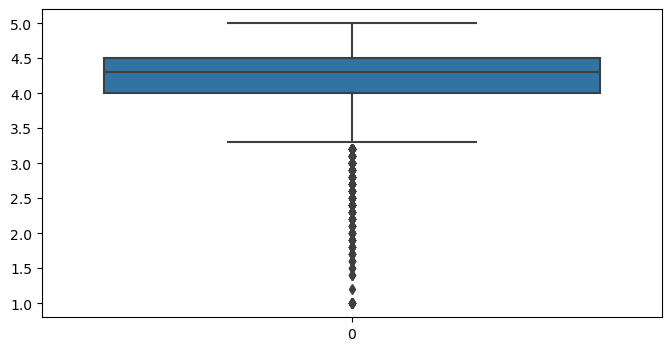

In [30]:
plt.figure(figsize=(8,4))
sns.boxplot(data["Rating"])

<Axes: >

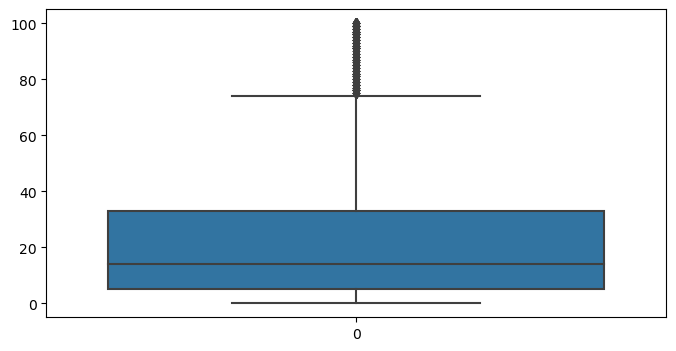

In [31]:
plt.figure(figsize=(8,4))
sns.boxplot(data["Size"])

<Axes: >

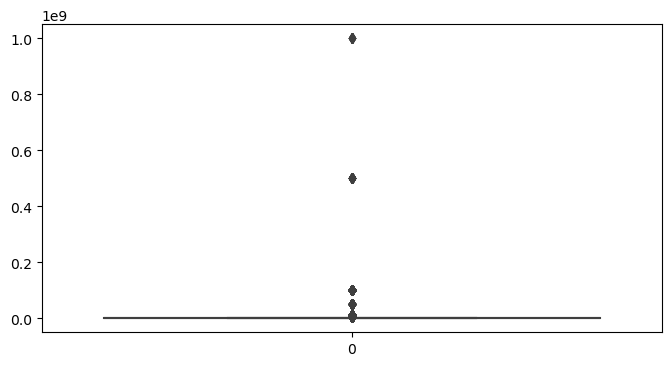

In [32]:
plt.figure(figsize=(8,4))
sns.boxplot(data["Installs"])

<Axes: >

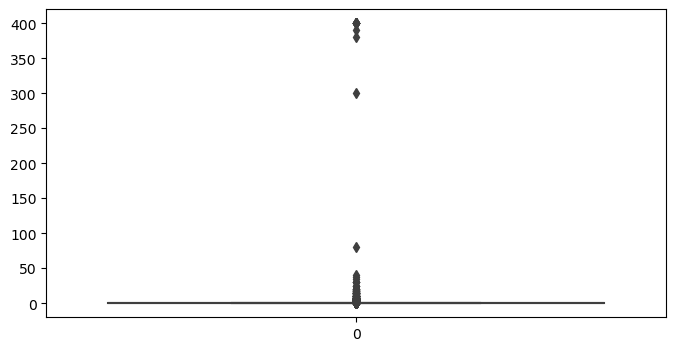

In [33]:
plt.figure(figsize=(8,4))
sns.boxplot(data["Price"])

### DB-SCAN

In [62]:
from sklearn.cluster import DBSCAN
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','days_since_last_update']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
dbscan = DBSCAN(eps=1, min_samples=5)
clusters_db = dbscan.fit_predict(features_scaled)
non_outlier_indices = (clusters_db != -1)
data_db = data[non_outlier_indices]
outliers_removed = len(data) - len(data_db)
data_db_preview = data_db[['Rating','Price', 'Reviews', 'Size', 'Installs','days_since_last_update']].head()
outliers_removed, data_db_preview


(45,
    Rating  Price  Reviews  Size  Installs  days_since_last_update
 0     4.1    0.0      159  19.0     10000                     213
 1     3.9    0.0      967  14.0    500000                     205
 2     4.7    0.0    87510   8.7   5000000                       7
 3     4.5    0.0   215644  25.0  50000000                      61
 4     4.3    0.0      967   2.8    100000                      49)

### IsolationForest

In [68]:
from sklearn.ensemble import IsolationForest
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','days_since_last_update']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
clf = IsolationForest(random_state=0)
clusters_if = clf.fit_predict(features_scaled)
non_outlier_indices_if = (clusters_if != -1)
data_if = data[non_outlier_indices_if]
outliers_removed = len(data) - len(data_if)
data_if_preview = data_if[['Rating','Price', 'Reviews', 'Size', 'Installs','days_since_last_update']]
outliers_removed, data_if_preview


(581,
        Rating  Price  Reviews    Size  Installs  days_since_last_update
 0         4.1    0.0      159  19.000     10000                     213
 1         3.9    0.0      967  14.000    500000                     205
 2         4.7    0.0    87510   8.700   5000000                       7
 3         4.5    0.0   215644  25.000  50000000                      61
 4         4.3    0.0      967   2.800    100000                      49
 ...       ...    ...      ...     ...       ...                     ...
 10833     4.8    0.0       44   0.619      1000                    1599
 10834     4.0    0.0        7   2.600       500                     416
 10836     4.5    0.0       38  53.000      5000                     379
 10837     5.0    0.0        4   3.600       100                      33
 10840     4.5    0.0   398307  19.000  10000000                      14
 
 [6841 rows x 6 columns])

### KNN

In [76]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

features = data[['Rating', 'Reviews', 'Price', 'Size', 'Installs', 'days_since_last_update']]

k = 5
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(features)

distances, indices = neigh.kneighbors(features)
kth_distances = distances[:, k-1]

threshold = np.percentile(kth_distances, 95)
outlier_indices = kth_distances > threshold
non_outlier_indices_knn = kth_distances <= threshold

data_knn = data[non_outlier_indices_knn]
outliers_removed_knn = len(data) - len(data_knn)

data_knn_preview = data_knn[['Rating', 'Price', 'Reviews', 'Size', 'Installs', 'days_since_last_update']]
outliers_removed_knn, data_knn_preview

(372,
        Rating  Price  Reviews    Size  Installs  days_since_last_update
 0         4.1    0.0      159  19.000     10000                     213
 1         3.9    0.0      967  14.000    500000                     205
 2         4.7    0.0    87510   8.700   5000000                       7
 4         4.3    0.0      967   2.800    100000                      49
 5         4.4    0.0      167   5.600     50000                     500
 ...       ...    ...      ...     ...       ...                     ...
 10833     4.8    0.0       44   0.619      1000                    1599
 10834     4.0    0.0        7   2.600       500                     416
 10836     4.5    0.0       38  53.000      5000                     379
 10837     5.0    0.0        4   3.600       100                      33
 10840     4.5    0.0   398307  19.000  10000000                      14
 
 [7050 rows x 6 columns])

In [ ]:
def cm(test_X,test_Y,model,str):
    y_pred = model.predict(test_X)
    cm = confusion_matrix(test_Y, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(test_Y, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score}')

    # Plotting the confusion matrix using seaborn
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

    # Labels, title and ticks
    label_classes = np.unique(test_Y)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Normalized Confusion Matrix of '+str)
    ax.xaxis.set_ticklabels(['1', '2', '3'])
    ax.yaxis.set_ticklabels(['1', '2', '3'])
    plt.show()

In [ ]:
from itertools import cycle
def ROC(train_Y,test_Y,model,str):
    y_score=model.predict_proba(test_X)
    label_binarizer = LabelBinarizer().fit(train_Y)
    y_onehot_test = label_binarizer.transform(test_Y)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    n_classes=y_onehot_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.style.use('ggplot')

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    for class_id in range(n_classes):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for quality {1+class_id}",
            ax=ax,
        )

    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',color='grey',label='chance')

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of "+str)
    plt.legend()
    plt.savefig("ROC.pdf")
    plt.show()